# 0. import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os, glob
import random
from tqdm import tqdm
from time import time




# 1. open cv 함수 사용
- test 이미지들이 open cv 의 data argumentation 사용한 것 같아 opencv를 이용

In [2]:
def brightness(gray, val):
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness = int(random.uniform(-val, val))
    if brightness > 0:
        gray = gray + brightness
    else:
        gray = gray - brightness
    gray = np.clip(gray, 10, 255)
    return gray

def contrast(gray, min_val, max_val):
    #gray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    alpha = int(random.uniform(min_val, max_val)) # Contrast control
    adjusted = cv2.convertScaleAbs(gray, alpha=alpha)
    return adjusted

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

def rotation(img, angle):
    # angle = int(random.uniform(-angle, angle))
    angle_list = [int(angle), 15, 25, 90, 45,90,180, 180] #조절
    angle = random.choice(angle_list)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img


def vertical_shift_down(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    img = fill(img, h, w)
    return img


def vertical_shift_up(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(0.0, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    img = fill(img, h, w)
    return img

def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img


def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img

def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img


# 2. 데이터 불균형 확인

In [3]:
#파일 경로 가져오기
PATH = './train/'

image_dirs = os.listdir(PATH)
image_paths = dict()
for image_dir in tqdm(image_dirs):
    try:
        files = glob.glob(PATH + image_dir+"/*.png") 
        image_paths[image_dir] = [file for file in files]
    except:
        FileNotFoundError

100%|██████████| 7/7 [00:00<00:00, 3494.42it/s]


In [4]:
#이미지 파일 & Label & filename & path 가져오기
import PIL
from PIL import Image
import torch
import torchvision
from torch.utils.data import  TensorDataset, DataLoader
from keras.preprocessing.image import img_to_array


data = dict()
data['label'] = []
data['filename'] = []
# data['image_arr'] = []
for label,paths in tqdm(image_paths.items()):
    for path in paths:
        img = Image.open(path)
        data['filename'].append(path)
        # data['image_arr'].append(img_arr)
        data['label'].append(label)

100%|██████████| 7/7 [00:00<00:00, 259.08it/s]


In [5]:
#파일 정보 확인 및 이미지 확인, data imbalance 확인 
from collections import Counter
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
# print('number of samples: ', len(data['image_arr']))
print('dict keys: ', list(data.keys()))
# print('image shape: ', data['image_arr'][0].shape)
count_label = Counter(data['label'])
print('Original dataset shape')
print(sorted(count_label.items()))

# #show images
# fig, axes = plt.subplots(1, len(count_label.items()))
# fig.set_size_inches(15,4)
# fig.tight_layout()
 
# for ax, label in zip(axes, np.unique(data['label'])):
#     idx = data['label'].index(label)
#     # ax.imshow(array_to_img(data['image_arr'][idx]))
#     ax.axis('off')
#     ax.set_title(label)

dict keys:  ['label', 'filename']
Original dataset shape
[('bottle-broken_large', 8), ('bottle-broken_small', 5), ('bottle-contamination', 7), ('cable-bent_wire', 7), ('cable-cable_swap', 6), ('cable-combined', 6), ('cable-cut_inner_insulation', 7)]


C:\Users\82109\anaconda3\envs\data\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


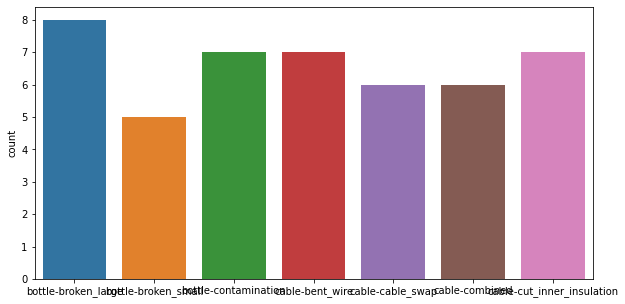

In [6]:
#imbalance 시각화
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data['label'])
plt.show()

# 3. Data Argumentation 실행

In [7]:
PATH = './train/'
image_dirs = os.listdir(PATH)
len_image_list = 0

label_count = Counter(data['label'])
label_max = max(label_count.values())


for image_dir in tqdm(image_dirs):
    image_list = os.listdir(PATH+image_dir+"/")
    len_image_list = len(image_list)

    while(len_image_list<label_max):   # 폴더에 생성할 갯수 설정
        
        for image in image_list:
            img = cv2.imread(PATH+image_dir+"/"+image)
            img = contrast(img, 1, 1.5)
            img = horizontal_flip(img, 1)
            img = rotation(img, 45)
            img = horizontal_shift(img, 0.1)
            img = vertical_shift_up(img, 0.1)
            img = vertical_shift_down(img, 0.1)

            file_name = PATH+image_dir+"/arumentation_"+str(time())+ '.png'
            cv2.imwrite(file_name, img)
            len_image_list += 1
            if len_image_list >= label_max:
                break;

    len_image_list = 0

            

        
            
          



100%|██████████| 7/7 [00:00<00:00,  9.75it/s]
